In [1]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import os
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-10-14 13:17:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-14 13:17:46 (94.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
#permet de connecter votre espace de stockage Google Drive à votre environnement Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Chemin d'accès au dossier contenant les images sur Google Drive
folder_path = '/content/drive/MyDrive/skiiiin2'

# Vérifiez si le dossier existe
if os.path.exists(folder_path):
    # Accédez au dossier
    os.chdir(folder_path)
    print(f"Dossier actuel : {os.getcwd()}")
else:
    print("Le dossier spécifié n'existe pas.")

Dossier actuel : /content/drive/MyDrive/skiiiin2


In [6]:
import tensorflow as tf

# Fix the random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

In [7]:
IMAGE_SHAPE = (224, 224 )

In [8]:
BATCH_SIZE = 32

In [9]:
image_dir = Path('/content/drive/MyDrive/skiiiin2')

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Menggabungkan lokasi letak file dan kategori
image_df = pd.concat([filepaths, labels], axis=1)

In [10]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/skiiiin2/blackhead/01F3...,blackhead
1,/content/drive/MyDrive/skiiiin2/blackhead/20.jpg,blackhead
2,/content/drive/MyDrive/skiiiin2/blackhead/blac...,blackhead
3,/content/drive/MyDrive/skiiiin2/blackhead/blac...,blackhead
4,/content/drive/MyDrive/skiiiin2/blackhead/blac...,blackhead
...,...,...
2297,/content/drive/MyDrive/skiiiin2/ride0/54.elder...,ride0
2298,/content/drive/MyDrive/skiiiin2/ride0/before-a...,ride0
2299,/content/drive/MyDrive/skiiiin2/ride0/63438a4e...,ride0
2300,/content/drive/MyDrive/skiiiin2/ride0/before-a...,ride0


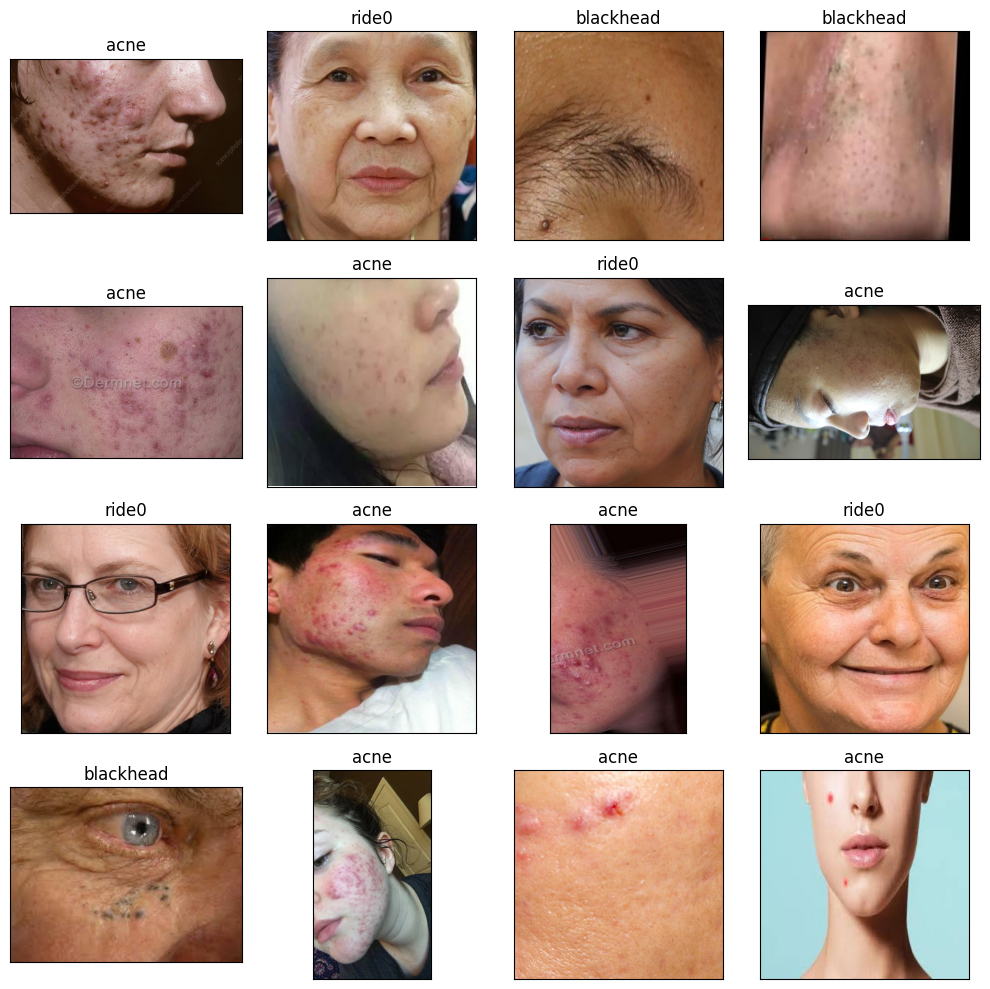

In [11]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [12]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)


In [13]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [14]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1473 validated image filenames belonging to 3 classes.
Found 368 validated image filenames belonging to 3 classes.
Found 461 validated image filenames belonging to 3 classes.


In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
# Create checkpoint callback
checkpoint_path = "disease_classification"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [18]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss",
# watch the val loss metric
                               patience = 5,
                               restore_best_weights = True)
# if val loss decreases for 3 epochs in a row, stop training

In [19]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "disease_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/disease_classification/20231014-131911
Epoch 1/50
31/47 [==================>...........] - ETA: 3:06 - loss: 0.6786 - accuracy: 0.7055

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


47/47 [==============================] - 697s 15s/step - loss: 0.5738 - accuracy: 0.7583 - val_loss: 0.3083 - val_accuracy: 0.8859
Epoch 2/50
47/47 [==============================] - 11s 242ms/step - loss: 0.2590 - accuracy: 0.9077 - val_loss: 0.2111 - val_accuracy: 0.9239
Epoch 3/50
47/47 [==============================] - 11s 240ms/step - loss: 0.1797 - accuracy: 0.9321 - val_loss: 0.1757 - val_accuracy: 0.9375
Epoch 4/50
47/47 [==============================] - 11s 229ms/step - loss: 0.1349 - accuracy: 0.9586 - val_loss: 0.1506 - val_accuracy: 0.9457
Epoch 5/50
47/47 [==============================] - 11s 241ms/step - loss: 0.1027 - accuracy: 0.9715 - val_loss: 0.1333 - val_accuracy: 0.9484
Epoch 6/50
47/47 [==============================] - 11s 226ms/step - loss: 0.1023 - accuracy: 0.9654 - val_loss: 0.1237 - val_accuracy: 0.9538
Epoch 7/50
47/47 [==============================] - 11s 231ms/step - loss: 0.0736 - accuracy: 0.9790 - val_loss: 0.1304 - val_accuracy: 0.9565
Epoch 8/50


In [20]:
train_loss, train_accuracy = model.evaluate(train_images)

print('Train Loss:', train_loss)
print('Train Accuracy:', train_accuracy)

47/47 [==============================] - 9s 180ms/step - loss: 0.0132 - accuracy: 0.9980
Train Loss: 0.013172507286071777
Train Accuracy: 0.9979633688926697


In [21]:
# Evaluate performance on train set
train_loss, train_accuracy = model.evaluate(train_images)

# Get predictions for each image in train generator
Y_train_pred = model.predict(train_images)
# Convert predictions from one-hot encoded to class labels (integers)
Y_train_pred_classes = np.argmax(Y_train_pred, axis=1)
# Convert true lables from generator to class labels (integers)
Y_train_true = train_images.classes

# Print classification report
class_report = classification_report(Y_train_true, Y_train_pred_classes, target_names=train_images.class_indices.keys())
print('Train classification report:')
print(class_report)

print('Train Loss:', train_loss)
print('Train Accuracy:', train_accuracy)

47/47 [==============================] - 10s 198ms/step
Train classification report:
              precision    recall  f1-score   support

        acne       0.43      0.42      0.43       624
   blackhead       0.12      0.12      0.12       124
       ride0       0.49      0.49      0.49       725

    accuracy                           0.43      1473
   macro avg       0.35      0.35      0.35      1473
weighted avg       0.43      0.43      0.43      1473

Train Loss: 0.013172503560781479
Train Accuracy: 0.9979633688926697


In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [23]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_images)

# Print the results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

15/15 [==============================] - 166s 12s/step - loss: 0.1441 - accuracy: 0.9566
Test Loss: 0.14414216578006744
Test Accuracy: 0.9566160440444946


In [24]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.14414
Test Accuracy: 95.66%


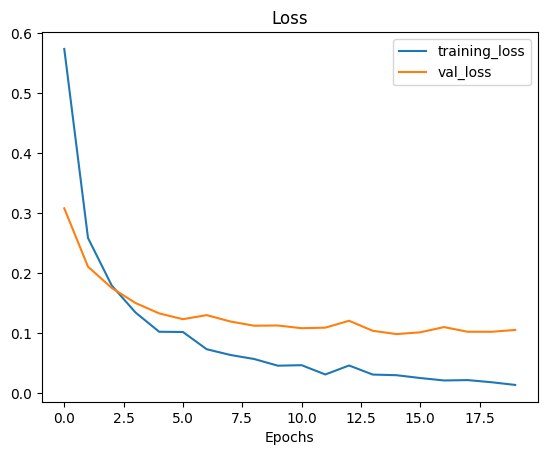

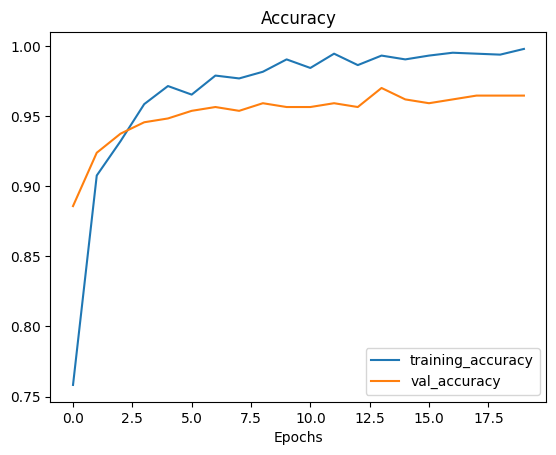

In [25]:
plot_loss_curves(history)

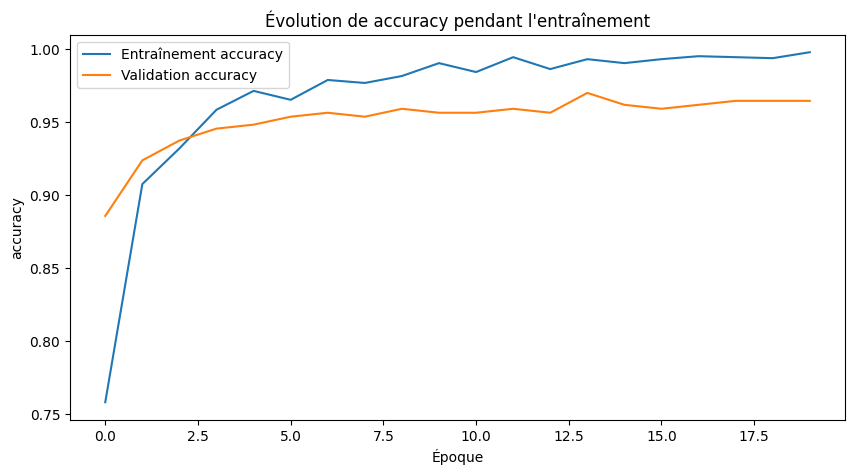

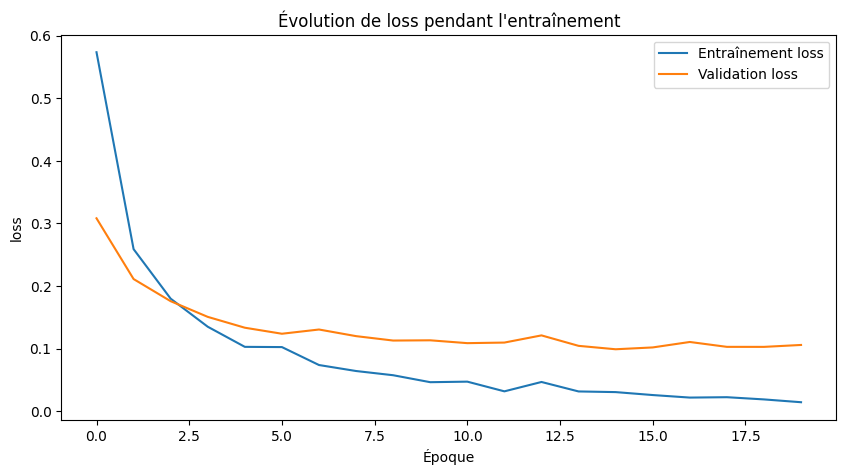

In [26]:
# Liste des métriques à afficher
metrics_to_plot = ['accuracy', 'loss']

# Créez un sous-tracé pour chaque métrique
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[metric], label='Entraînement ' + metric)
    plt.plot(history.history['val_' + metric], label='Validation ' + metric)
    plt.xlabel('Époque')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f'Évolution de {metric} pendant l\'entraînement')

# Affichage des graphiques
plt.show()

In [27]:
train_pred = np.argmax(model.predict(train_images), axis=1)
train_true = train_images.classes

print("Classification Report on Train:")
print(classification_report(train_true, train_pred))

15/47 [========>.....................] - ETA: 5s

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


47/47 [==============================] - 9s 184ms/step
Classification Report on Train:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40       624
           1       0.06      0.06      0.06       124
           2       0.48      0.49      0.49       725

    accuracy                           0.41      1473
   macro avg       0.32      0.32      0.32      1473
weighted avg       0.41      0.41      0.41      1473



In [28]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 2 predictions: {pred[:2]}')

15/15 [==============================] - 3s 165ms/step
The first 2 predictions: ['acne', 'ride0']


In [29]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [30]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        acne       0.95      0.96      0.95       200
   blackhead       0.82      0.79      0.81        34
       ride0       0.99      0.98      0.98       227

    accuracy                           0.96       461
   macro avg       0.92      0.91      0.91       461
weighted avg       0.96      0.96      0.96       461



In [31]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
acne,0.945813,0.960000,0.952854,200.000000
blackhead,0.818182,0.794118,0.805970,34.000000
ride0,0.986667,0.977974,0.982301,227.000000
accuracy,0.956616,0.956616,0.956616,0.956616
macro avg,0.916887,0.910697,0.913708,461.000000
weighted avg,0.956516,0.956616,0.956521,461.000000


In [32]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """
     # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

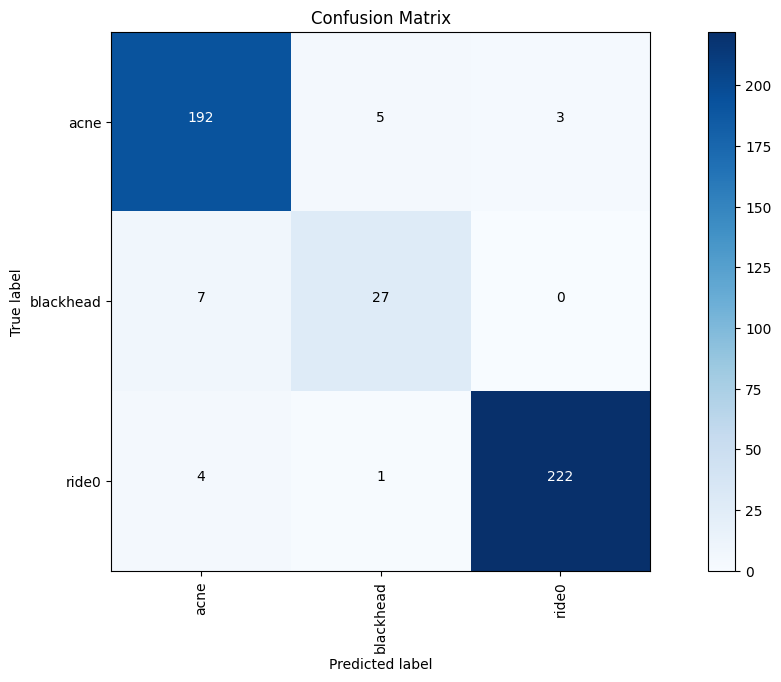

In [33]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [34]:
# Créez un dossier pour sauvegarder le modèle (s'il n'existe pas déjà)
save_dir = '/content/drive/MyDrive/saved_models'  # Remplacez cet emplacement par l'emplacement souhaité
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Sauvegardez le modèle en tant que fichier .h5
model.save(os.path.join(save_dir, 'mon_modele.h5'))


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
